# Exercise on using Gaia archive

**Students**: Francesca Borg, Thara Rubi Caba Pineda, Nandita Das, Shoaib Shamsi<br>
**Course**: Big Data in Space Science

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astroquery.gaia import Gaia

In [2]:
# Gaia.login(credentials_file='gaia_credentials') # Uncomment if you have credentials and would like to login.

## Downloading the data

The data was first retreived and downloading from the [Gaia archive server](https://gea.esac.esa.int/archive/) using TAP+ in the `astroquery.Gaia` module. We apply some specific quality constraints and download the data.

In [3]:
count_query ='''
SELECT COUNT(*)

FROM gaiadr3.gaia_source as g

WHERE g.parallax > 0
    AND g.parallax_over_error > 10
    AND g.visibility_periods_used > 8
    AND g.phot_g_mean_flux_over_error > 50
    AND g.phot_bp_mean_flux_over_error > 20
    AND g.phot_rp_mean_flux_over_error > 20
    AND g.phot_bp_rp_excess_factor < 1.3 + 0.06 * power(g.phot_bp_mean_mag - g.phot_rp_mean_mag, 2)
    AND g.phot_bp_rp_excess_factor > 1.0 + 0.015 * power(g.phot_bp_mean_mag - g.phot_rp_mean_mag, 2)
    AND g.astrometric_chi2_al / (g.astrometric_n_good_obs_al - 5) <
        1.44 * greatest(1, exp(-0.4 * (g.phot_g_mean_mag - 19.5)))
'''

# count_job = Gaia.launch_job_async(count_query, background=True)

In [4]:
# count_job_data = count_job.get_data()
# count_job_data.write('all_counts.csv', format='csv', overwrite=True)

In [5]:
all_counts = pd.read_csv('all_counts.csv').iloc[0][0]
print('There are {} plottable Gaia stars'.format(all_counts))

There are 91316510 plottable Gaia stars


Let's download these data

In [6]:
data_query ='''
SELECT g.parallax, g.phot_g_mean_mag, g.bp_rp

FROM gaiadr3.gaia_source as g

WHERE g.parallax > 0
    AND g.parallax_over_error > 10
    AND g.visibility_periods_used > 8
    AND g.phot_g_mean_flux_over_error > 50
    AND g.phot_bp_mean_flux_over_error > 20
    AND g.phot_rp_mean_flux_over_error > 20
    AND g.phot_bp_rp_excess_factor < 1.3 + 0.06 * power(g.phot_bp_mean_mag - g.phot_rp_mean_mag, 2)
    AND g.phot_bp_rp_excess_factor > 1.0 + 0.015 * power(g.phot_bp_mean_mag - g.phot_rp_mean_mag, 2)
    AND g.astrometric_chi2_al / (g.astrometric_n_good_obs_al - 5) <
        1.44 * greatest(1, exp(-0.4 * (g.phot_g_mean_mag - 19.5)))
'''

# data_job = Gaia.launch_job_async(data_query, background=True)

In [7]:
### We download and save this data in `gaia_data.csv
data = dd.read_csv('gaia_data_plx0_sID.csv')

In [8]:
data.dropna()
data = data[(data['in_galaxy_candidates'] == False) & (data['in_qso_candidates'] == False) & (data['non_single_star'] == 0)]
data = data.drop(['source_id', 'in_qso_candidates', 'in_galaxy_candidates', 'non_single_star'], axis=1)
data['distance_pc'] = 1000 / data['parallax']  # distance in parsecs
data.head()

,parallax,phot_g_mean_mag,bp_rp,distance_pc
0,0.652128,14.625587,1.332325,1533.440645
1,1.468394,14.039069,1.179402,681.016174
2,1.546201,17.399897,2.028242,646.746635
3,0.904441,15.853853,1.207551,1105.654764
4,0.795907,15.426225,1.228890,1256.428243


In [9]:
upto_200pc = len(data[data['distance_pc'] < 200])

In [10]:
print(f'There are {all_counts} stars with our filters.')
print(f'The distances of {upto_200pc} ({100 * upto_200pc/all_counts:.3f}%) of these stars are <= 200 pc.')

There are 91316510 stars with our filters.
The distances of 1398516 (1.532%) of these stars are <= 200 pc.


## Plotting the HR diagram

In [11]:
data = pd.read_csv('gaia_data_smaller.csv')
print(f'This DF is too large to be processed with `matplotlib` on our laptops. We instead take a subset of {len(data)} stars.')

This DF is too large to be processed with `matplotlib` on our laptops. We instead take a subset of 1433622 stars.


In [12]:
# Convert parallax in milliarcseconds to parsecs, and calculate the Absolute g magnitude
data['distance_pc'] = 1000 / data['parallax']  # distance in parsecs
data['abs_g'] = data['phot_g_mean_mag'] - 5 * (np.log10(data['distance_pc']) - 1)

In [13]:
gaia_x = data['bp_rp'].to_numpy()
gaia_y = data['abs_g'].to_numpy()

def colour2temp(B_minus_V):
    return 4600 * ((1 / (0.92 * B_minus_V + 1.7)) + (1 / (0.92 * B_minus_V + 0.62)))
    # return 4600 * (1 / (0.92 * B_minus_V + 1.7))

def temp2colour(temp):
    # return (7060 / temp) - 0.706
    return (np.sqrt(729 + (52_900_000_000 / temp**2)) -58 + (230_000 / temp)) / 46

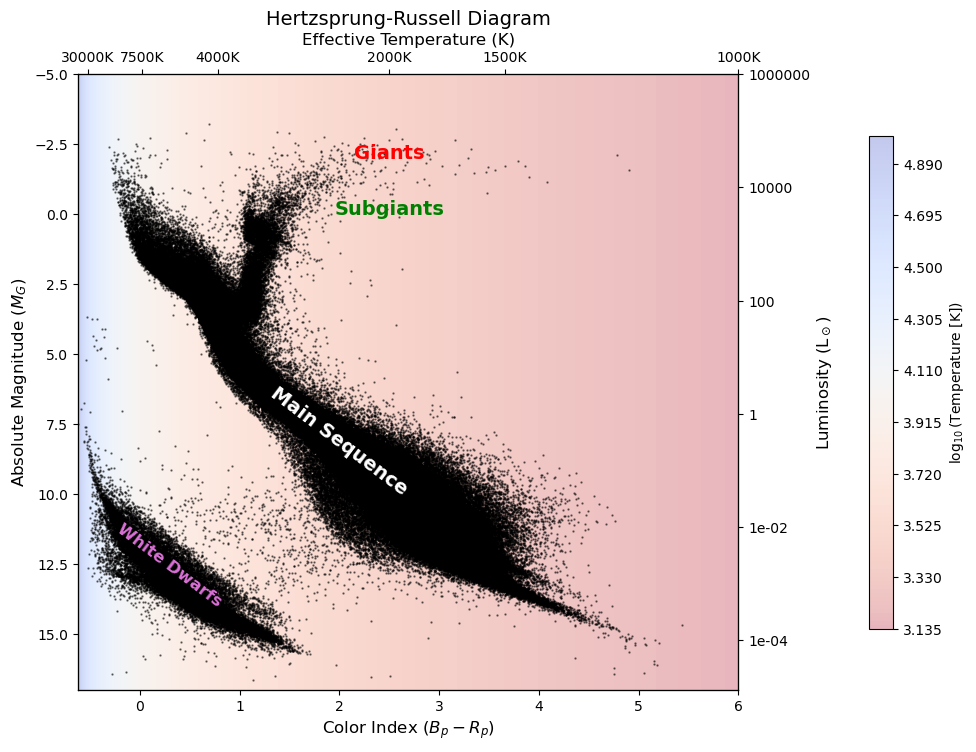

In [14]:
x_min = -0.62
x_max = 6
y_min = -5
y_max = 17

# Set up a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define background color mesh to represent temperature gradient
x = np.linspace(x_min, x_max, 200)  # Approximate color index range (B - V)
y = np.linspace(y_max, y_min, 200)    # Approximate absolute magnitude range (Mv)
X, Y = np.meshgrid(x, y)

# Calculate an approximate temperature gradient for shading
temperatures = colour2temp(X)

# Display background temperature contour with a cool-to-warm gradient
contour = ax.contourf(X, Y, np.log10(temperatures), levels=150, cmap="coolwarm_r", alpha=0.3)
cbar = plt.colorbar(contour, ax=ax, pad=0.14, shrink=0.8)  # Increase `pad` and decrease `shrink`
cbar.set_label('$\log_{10}$(Temperature [K])')

# Set limits based on expected data range
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)

# Axis labels
ax.set_xlabel("Color Index ($B_p - R_p$)", fontsize=12)
ax.set_ylabel("Absolute Magnitude ($M_G$)", fontsize=12)
plt.title("Hertzsprung-Russell Diagram", fontsize=14)

# Top axis: Effective temperature in K
temp_ticks = np.array([30000, 7500, 4000, 2000, 1500, 1000])  # Temperature values
color_ticks = temp2colour(temp_ticks)  # Convert to color index range
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(color_ticks)
ax2.set_xticklabels([f"{int(temp)}K" for temp in temp_ticks])
ax2.set_xlabel("Effective Temperature (K)", fontsize=12)

# Right axis: Luminosity relative to the Sun (L/Lsun)
luminosity_ticks = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6]  # Luminosity values in L/Lsun
magnitude_ticks = 4.8 - 2.5 * np.log10(luminosity_ticks)  # Convert to absolute magnitude
ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_yticks(magnitude_ticks)
ax3.set_yticklabels([f"{int(lum) if lum >= 1 else f'{lum:.0e}'}" for lum in luminosity_ticks])
ax3.set_ylabel("Luminosity (L$_\odot$)", fontsize=12)

#plot the data
ax.scatter(gaia_x, gaia_y, s=0.5, c='black', alpha=0.5)

# Labels for regions
ax.text(2, 10, 'Main Sequence', rotation=-37, fontsize=14, color="white", ha='center', weight = 'bold')
ax.text(0.3, 14, 'White Dwarfs', rotation=-37, fontsize=12, color="orchid", ha='center', weight = 'bold')
ax.text(2.5, -2, 'Giants', fontsize=14, color="red", ha='center', weight = 'bold')
ax.text(2.5, 0, 'Subgiants', fontsize=14, color="green", ha='center', weight = 'bold')

plt.show()

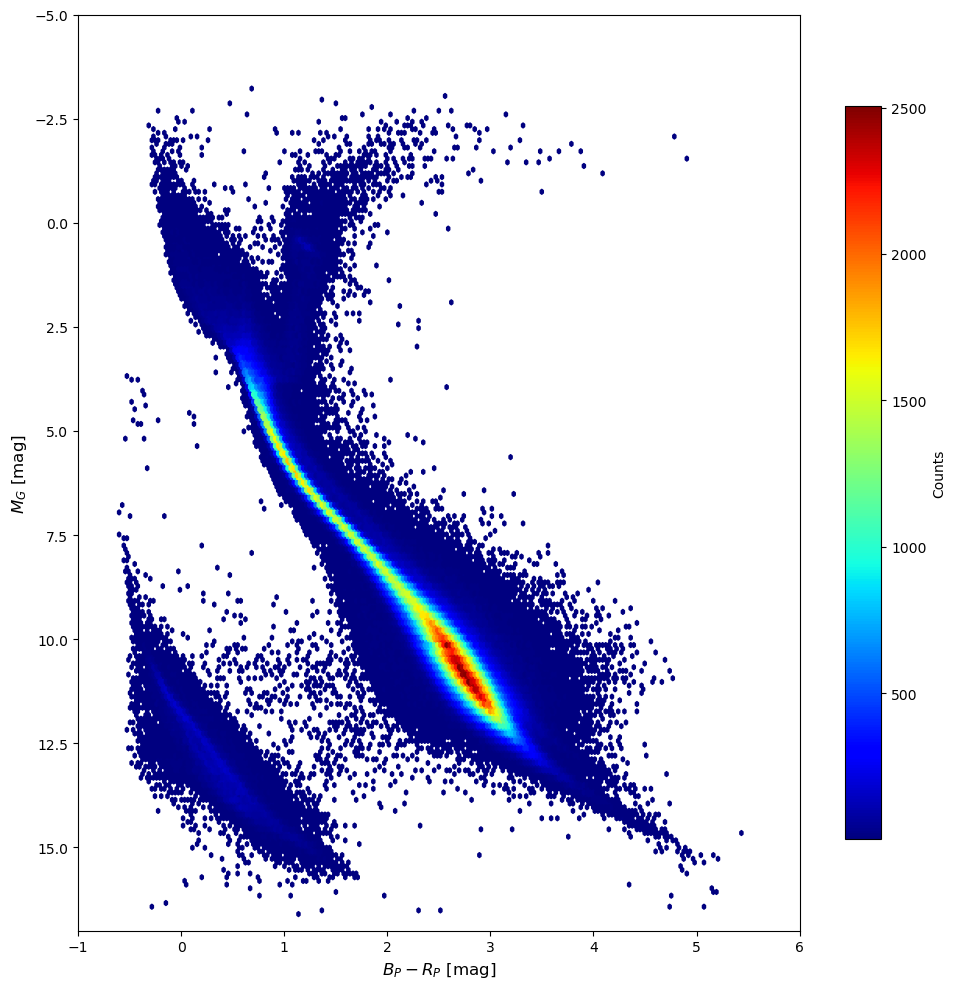

In [15]:
plt.figure(figsize=(10, 10))
hb = plt.hexbin(gaia_x, gaia_y, gridsize=200, cmap='jet', mincnt=1)

# Adding color bar
cb = plt.colorbar(hb, pad=0.05, shrink=0.8)
cb.set_label("Counts")

# Axis labels
plt.xlabel(r"$B_P - R_P$ [mag]", fontsize=12)
plt.ylabel(r"$M_{G}$ [mag]", fontsize=12)

# Invert y-axis to match astronomical conventions (brighter stars at the top)
plt.gca().invert_yaxis()

# Set limits based on expected data range
plt.xlim(-1, 6.0)
plt.ylim(17, -5)

# Show plot
plt.tight_layout()
plt.show()

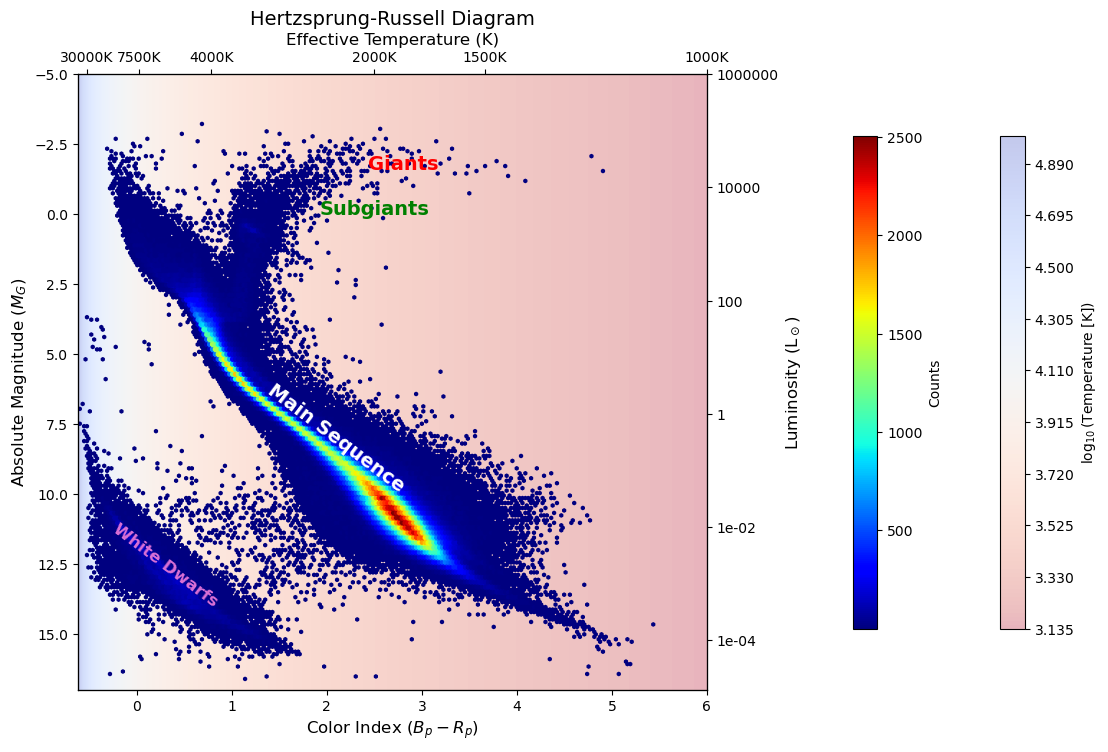

In [16]:
x_min = -0.62
x_max = 6
y_min = -5
y_max = 17

# Set up a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Define background color mesh to represent temperature gradient
x = np.linspace(x_min, x_max, 200)  # Approximate color index range (B - V)
y = np.linspace(y_max, y_min, 200)    # Approximate absolute magnitude range (Mv)
X, Y = np.meshgrid(x, y)

# Calculate an approximate temperature gradient for shading
temperatures = colour2temp(X)

# Display background temperature contour with a cool-to-warm gradient
contour = ax.contourf(X, Y, np.log10(temperatures), levels=150, cmap="coolwarm_r", alpha=0.3)
cbar = plt.colorbar(contour, ax=ax, pad=0.01, shrink=0.8)  # Increase `pad` and decrease `shrink`
cbar.set_label('$\log_{10}$(Temperature [K])')

# Set limits based on expected data range
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)

# Axis labels
ax.set_xlabel("Color Index ($B_p - R_p$)", fontsize=12)
ax.set_ylabel("Absolute Magnitude ($M_G$)", fontsize=12)
plt.title("Hertzsprung-Russell Diagram", fontsize=14)

# Top axis: Effective temperature in K
temp_ticks = np.array([30000, 7500, 4000, 2000, 1500, 1000])  # Temperature values
color_ticks = temp2colour(temp_ticks)  # Convert to color index range
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(color_ticks)
ax2.set_xticklabels([f"{int(temp)}K" for temp in temp_ticks])
ax2.set_xlabel("Effective Temperature (K)", fontsize=12)

# Right axis: Luminosity relative to the Sun (L/Lsun)
luminosity_ticks = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6]  # Luminosity values in L/Lsun
magnitude_ticks = 4.8 - 2.5 * np.log10(luminosity_ticks)  # Convert to absolute magnitude
ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_yticks(magnitude_ticks)
ax3.set_yticklabels([f"{int(lum) if lum >= 1 else f'{lum:.0e}'}" for lum in luminosity_ticks])
ax3.set_ylabel("Luminosity (L$_\odot$)", fontsize=12)

#plot the data
hb = ax.hexbin(gaia_x, gaia_y, gridsize=200, cmap='jet', mincnt=1)
count_cbar = plt.colorbar(hb, ax=ax, pad=0.16, shrink=0.8)
count_cbar.set_label("Counts")
# ax.scatter(gaia_x, gaia_y, s=0.5, c='black', alpha=0.5)

# Labels for regions
ax.text(2.1, 9.9, 'Main Sequence', rotation=-37, fontsize=14, color="white", ha='center', weight = 'bold')
ax.text(0.3, 14, 'White Dwarfs', rotation=-37, fontsize=12, color="orchid", ha='center', weight = 'bold')
ax.text(2.8, -1.6, 'Giants', fontsize=14, color="red", ha='center', weight = 'bold')
ax.text(2.5, 0, 'Subgiants', fontsize=14, color="green", ha='center', weight = 'bold')

plt.show()

## Comparison with Hipparcos

In [17]:
### Let's download the Hipparcos data. It is 2MB, so we'll download it all

hipparcos_query = '''
SELECT h.plx, h.e_plx, h.hpmag, h.e_hpmag, h.b_v, h.e_b_v, h.v_i, h.e_v_i, h.vmag

FROM public.hipparcos AS h
'''

# hipparcos_job = Gaia.launch_job_async(hipparcos_query, background=True)

In [18]:
# hipparcos_df = hipparcos_job.get_data().to_pandas()
# hipparcos_df.to_csv('hipparcos.csv', index=False)

In [19]:
hipparcos_df = pd.read_csv('hipparcos.csv')
hipparcos_df

,plx,e_plx,hpmag,e_hpmag,b_v,e_b_v,v_i,e_v_i,vmag
0,3.54,1.39,9.2043,0.0020,0.482,0.025,0.55,0.03,9.10
1,21.90,3.10,9.4017,0.0017,0.999,0.002,1.04,0.00,9.27
2,2.81,0.63,6.6081,0.0007,-0.019,0.004,0.00,0.00,6.61
3,7.75,0.97,8.1498,0.0011,0.370,0.009,0.43,0.01,8.06
4,2.87,1.11,8.7077,0.0018,0.902,0.013,0.90,0.01,8.55
...,...,...,...,...,...,...,...,...,...
118213,1.92,0.91,7.1043,0.0018,1.595,0.013,1.61,0.01,6.99
118214,10.63,1.17,8.3699,0.0014,0.639,0.015,0.70,0.01,8.23
118215,5.00,1.01,7.7604,0.0010,0.999,0.012,0.98,0.01,7.59
118216,19.22,1.00,9.3312,0.0019,0.698,0.003,0.75,0.00,9.20


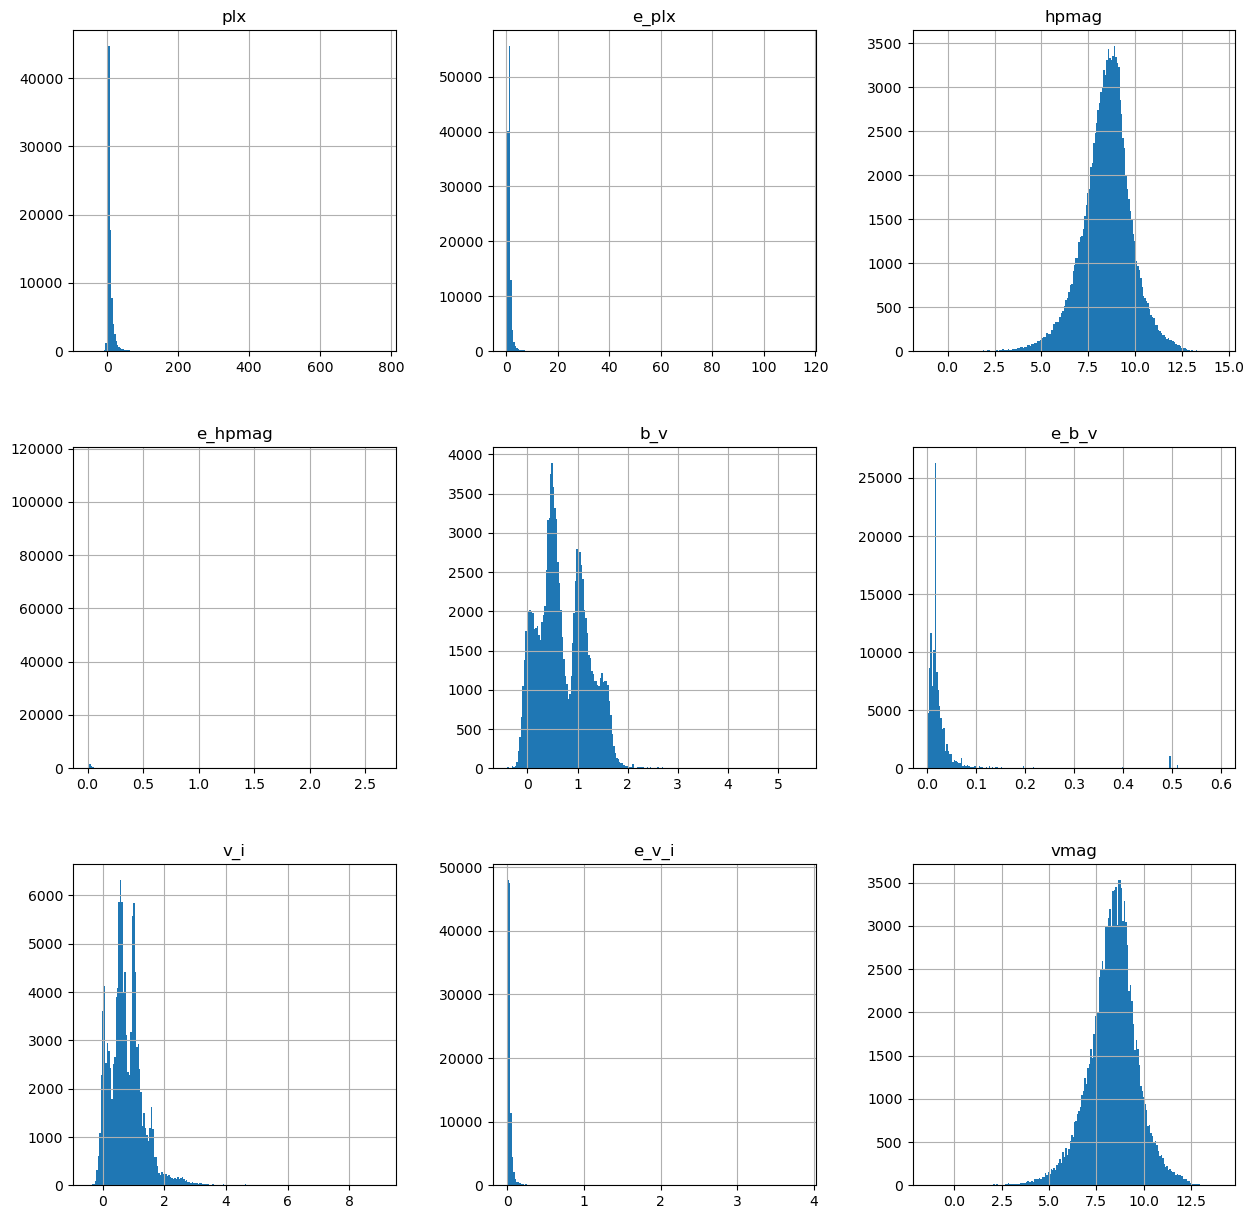

In [20]:
_junk = hipparcos_df.hist(figsize=(15, 15), bins=200)

In [21]:
error_cols = ['e_plx', 'e_hpmag', 'e_b_v', 'e_v_i']
hipparcos_df = hipparcos_df[(hipparcos_df[error_cols] > 0).all(axis=1)]
hipparcos_df = hipparcos_df[((hipparcos_df['plx'] / hipparcos_df['e_plx']) > 5) &
                ((hipparcos_df['hpmag'] / hipparcos_df['e_hpmag']) > 5) &
                ((hipparcos_df['b_v'] / hipparcos_df['e_b_v']) > 5) &
                ((hipparcos_df['v_i'] / hipparcos_df['e_v_i']) > 5)]
hipparcos_df

,plx,e_plx,hpmag,e_hpmag,b_v,e_b_v,v_i,e_v_i,vmag
3,7.75,0.97,8.1498,0.0011,0.370,0.009,0.43,0.01,8.06
6,17.74,1.30,9.6795,0.0021,0.740,0.020,0.79,0.02,9.64
9,10.76,1.10,8.6994,0.0020,0.489,0.011,0.56,0.01,8.59
10,4.29,0.84,7.3777,0.0010,0.081,0.007,0.09,0.01,7.34
13,5.11,0.99,7.4195,0.0009,1.200,0.015,1.16,0.01,7.25
...,...,...,...,...,...,...,...,...,...
118204,5.87,0.85,6.7929,0.0008,0.146,0.008,0.16,0.01,6.74
118205,39.43,1.36,8.9930,0.0015,1.187,0.052,1.15,0.05,8.85
118206,7.22,1.11,8.4901,0.0019,0.724,0.014,0.78,0.01,8.35
118207,24.63,2.96,11.9884,0.0058,1.391,0.014,1.65,0.04,11.85


In [22]:
hipparcos_df['distance_pc'] = 1000 / hipparcos_df['plx']  # distance in parsecs
hipparcos_df['abs_hpmag'] = hipparcos_df['hpmag'] - 5 * (np.log10(hipparcos_df['distance_pc']) - 1)
hipparcos_df['abs_vmag'] = hipparcos_df['vmag'] - 5 * (np.log10(hipparcos_df['distance_pc']) - 1)
hipparcos_df

,plx,e_plx,hpmag,e_hpmag,b_v,e_b_v,v_i,e_v_i,vmag,distance_pc,abs_hpmag,abs_vmag
3,7.75,0.97,8.1498,0.0011,0.370,0.009,0.43,0.01,8.06,129.032258,2.596309,2.506509
6,17.74,1.30,9.6795,0.0021,0.740,0.020,0.79,0.02,9.64,56.369786,5.924268,5.884768
9,10.76,1.10,8.6994,0.0020,0.489,0.011,0.56,0.01,8.59,92.936803,3.858461,3.749061
10,4.29,0.84,7.3777,0.0010,0.081,0.007,0.09,0.01,7.34,233.100233,0.539986,0.502286
13,5.11,0.99,7.4195,0.0009,1.200,0.015,1.16,0.01,7.25,195.694716,0.961605,0.792105
...,...,...,...,...,...,...,...,...,...,...,...,...
118204,5.87,0.85,6.7929,0.0008,0.146,0.008,0.16,0.01,6.74,170.357751,0.636091,0.583191
118205,39.43,1.36,8.9930,0.0015,1.187,0.052,1.15,0.05,8.85,25.361400,6.972134,6.829134
118206,7.22,1.11,8.4901,0.0019,0.724,0.014,0.78,0.01,8.35,138.504155,2.782786,2.642686
118207,24.63,2.96,11.9884,0.0058,1.391,0.014,1.65,0.04,11.85,40.600893,8.945722,8.807322


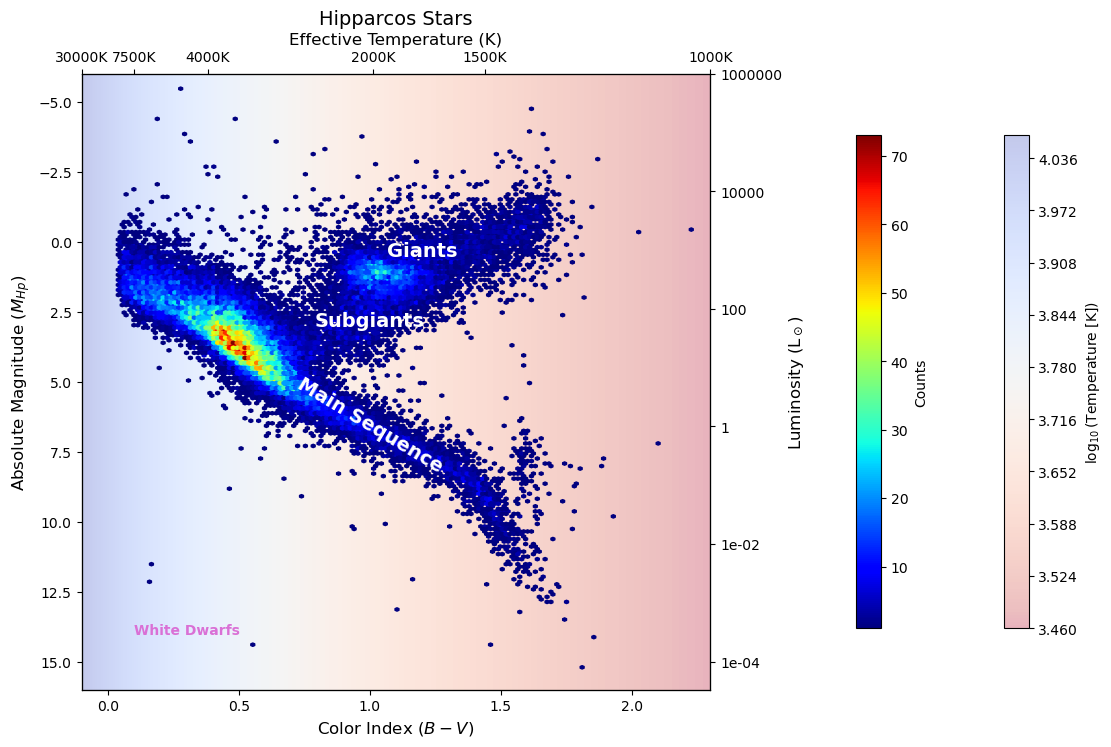

In [23]:
x_min = -0.1
x_max = 2.3
y_min = -6
y_max = 16

hipparcos_x = hipparcos_df['b_v']
hipparcos_y = hipparcos_df['abs_hpmag']

# Set up a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Define background color mesh to represent temperature gradient
x = np.linspace(x_min, x_max, 200)  # Approximate color index range (B - V)
y = np.linspace(y_max, y_min, 200)    # Approximate absolute magnitude range (Mv)
X, Y = np.meshgrid(x, y)

# Calculate an approximate temperature gradient for shading
temperatures = colour2temp(X)

# Display background temperature contour with a cool-to-warm gradient
contour = ax.contourf(X, Y, np.log10(temperatures), levels=150, cmap="coolwarm_r", alpha=0.3)
cbar = plt.colorbar(contour, ax=ax, pad=0.01, shrink=0.8)  # Increase `pad` and decrease `shrink`
cbar.set_label('$\log_{10}$(Temperature [K])')

# Set limits based on expected data range
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)

# Axis labels
ax.set_xlabel("Color Index ($B - V$)", fontsize=12)
ax.set_ylabel("Absolute Magnitude ($M_{Hp}$)", fontsize=12)
plt.title("Hipparcos Stars", fontsize=14)

# Top axis: Effective temperature in K
temp_ticks = np.array([30000, 7500, 4000, 2000, 1500, 1000])  # Temperature values
color_ticks = temp2colour(temp_ticks)  # Convert to color index range
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(color_ticks)
ax2.set_xticklabels([f"{int(temp)}K" for temp in temp_ticks])
ax2.set_xlabel("Effective Temperature (K)", fontsize=12)

# Right axis: Luminosity relative to the Sun (L/Lsun)
luminosity_ticks = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6]  # Luminosity values in L/Lsun
magnitude_ticks = 4.8 - 2.5 * np.log10(luminosity_ticks)  # Convert to absolute magnitude
ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_yticks(magnitude_ticks)
ax3.set_yticklabels([f"{int(lum) if lum >= 1 else f'{lum:.0e}'}" for lum in luminosity_ticks])
ax3.set_ylabel("Luminosity (L$_\odot$)", fontsize=12)

#plot the data
hb = ax.hexbin(hipparcos_x, hipparcos_y, gridsize=200, cmap='jet', mincnt=1)
count_cbar = plt.colorbar(hb, ax=ax, pad=0.16, shrink=0.8)
count_cbar.set_label("Counts")
# ax.scatter(gaia_x, gaia_y, s=0.5, c='black', alpha=0.5)

# Labels for regions
ax.text(1, 8.2, 'Main Sequence', rotation=-31, fontsize=14, color="white", ha='center', weight = 'bold')
ax.text(0.3, 14, 'White Dwarfs', rotation=0, fontsize=10, color="orchid", ha='center', weight = 'bold')
ax.text(1.2, 0.5, 'Giants', fontsize=14, color="white", ha='center', weight = 'bold')
ax.text(1, 3, 'Subgiants', fontsize=14, color="white", ha='center', weight = 'bold')

plt.show()

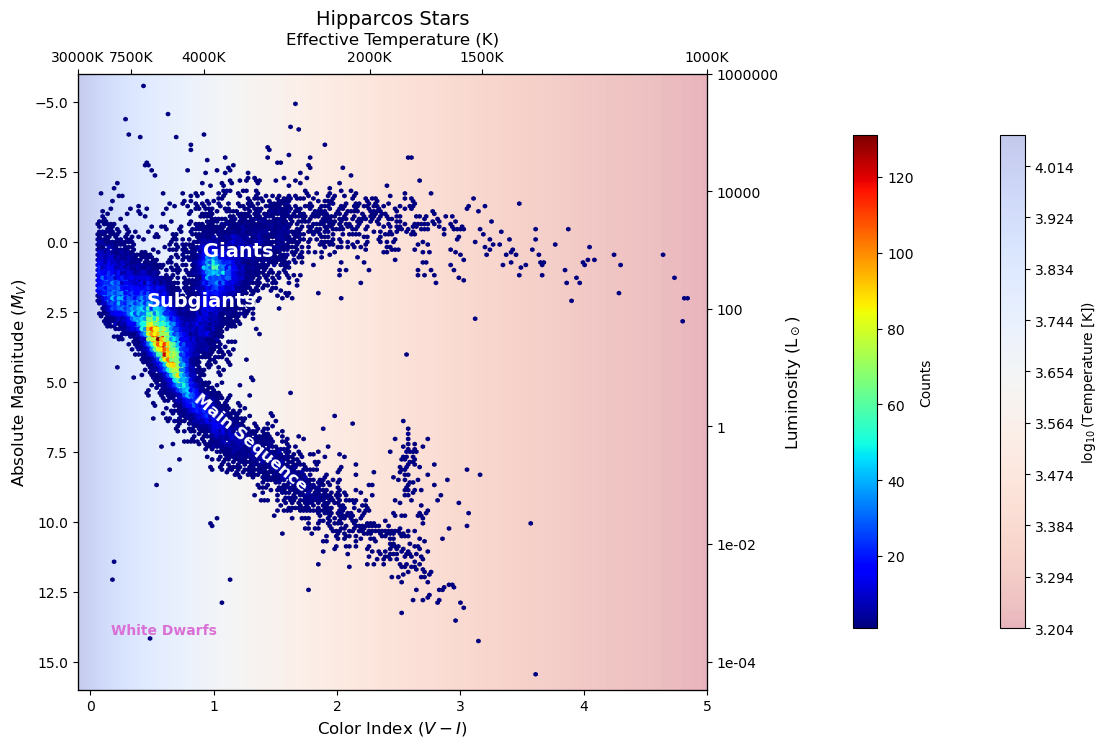

In [24]:
x_min = -0.1
x_max = 5
y_min = -6
y_max = 16

hipparcos_x = hipparcos_df['v_i']
hipparcos_y = hipparcos_df['abs_vmag']

# Set up a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Define background color mesh to represent temperature gradient
x = np.linspace(x_min, x_max, 200)  # Approximate color index range (B - V)
y = np.linspace(y_max, y_min, 200)    # Approximate absolute magnitude range (Mv)
X, Y = np.meshgrid(x, y)

# Calculate an approximate temperature gradient for shading
temperatures = colour2temp(X)

# Display background temperature contour with a cool-to-warm gradient
contour = ax.contourf(X, Y, np.log10(temperatures), levels=150, cmap="coolwarm_r", alpha=0.3)
cbar = plt.colorbar(contour, ax=ax, pad=0.01, shrink=0.8)  # Increase `pad` and decrease `shrink`
cbar.set_label('$\log_{10}$(Temperature [K])')

# Set limits based on expected data range
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)

# Axis labels
ax.set_xlabel("Color Index ($V - I$)", fontsize=12)
ax.set_ylabel("Absolute Magnitude ($M_{V}$)", fontsize=12)
plt.title("Hipparcos Stars", fontsize=14)

# Top axis: Effective temperature in K
temp_ticks = np.array([30000, 7500, 4000, 2000, 1500, 1000])  # Temperature values
color_ticks = temp2colour(temp_ticks)  # Convert to color index range
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(color_ticks)
ax2.set_xticklabels([f"{int(temp)}K" for temp in temp_ticks])
ax2.set_xlabel("Effective Temperature (K)", fontsize=12)

# Right axis: Luminosity relative to the Sun (L/Lsun)
luminosity_ticks = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6]  # Luminosity values in L/Lsun
magnitude_ticks = 4.8 - 2.5 * np.log10(luminosity_ticks)  # Convert to absolute magnitude
ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_yticks(magnitude_ticks)
ax3.set_yticklabels([f"{int(lum) if lum >= 1 else f'{lum:.0e}'}" for lum in luminosity_ticks])
ax3.set_ylabel("Luminosity (L$_\odot$)", fontsize=12)

#plot the data
hb = ax.hexbin(hipparcos_x, hipparcos_y, gridsize=200, cmap='jet', mincnt=1)
count_cbar = plt.colorbar(hb, ax=ax, pad=0.16, shrink=0.8)
count_cbar.set_label("Counts")
# ax.scatter(gaia_x, gaia_y, s=0.5, c='black', alpha=0.5)

# Labels for regions
ax.text(1.3, 8.9, 'Main Sequence', rotation=-40, fontsize=12, color="white", ha='center', weight = 'bold')
ax.text(0.6, 14, 'White Dwarfs', rotation=0, fontsize=10, color="orchid", ha='center', weight = 'bold')
ax.text(1.2, 0.5, 'Giants', fontsize=14, color="white", ha='center', weight = 'bold')
ax.text(0.9, 2.3, 'Subgiants', fontsize=14, color="white", ha='center', weight = 'bold')

plt.show()

Comparisons:
- Overall population!
- White dwarf population
- Better blue giant population
- Colour index ranges
- Highest population concentration at a much higher magnitude for Gaia

## References

- Advanced (ADQL) search tool on https://gea.esac.esa.int/archive/